In [1]:
###########
# PRELUDE #
###########

# auto-reload changed python files
%load_ext autoreload
%autoreload 2

# Format cells with %%black
%load_ext blackcellmagic

# nice interactive plots
%matplotlib inline

# add repository directory to include path
from pathlib import Path
import sys
PROJECT_DIR = Path('../..').resolve()
sys.path.append(str(PROJECT_DIR))

from IPython.display import display, Markdown
def markdown(s):
    return display(Markdown(s))

markdown("Surround markdown cells with  `<div class=\"alert alert-block alert-info\">\\n\\n ... \\n\\n</div>` to mark professor-provided assignment content")

Surround markdown cells with  `<div class="alert alert-block alert-info">\n\n ... \n\n</div>` to mark professor-provided assignment content

<div class="alert alert-block alert-info">

# Part 1: The Power of Two Choices

</div>

In [2]:
from collections import Counter
import matplotlib.pyplot as plt
from random import randrange, choice as randchoice
from tqdm import trange

<div class="alert alert-block alert-info">

## Goal

The goal of this part of the assignment is to gain an appreciation for the unreasonable effectiveness of simple randomized load balancing, and measure the benefits of some lightweight optimizations.

</div>

<div class="alert alert-block alert-info">

## Description
We consider random processes of the following type: there are N bins, and we throw N
balls into them, one by one. \[This is an abstraction of the sort of allocation problem that arises throughout computing—e.g. allocating tasks on servers, routing packets within parallel networks, etc..] We’ll compare four different strategies for choosing the bin in which to place a given ball.

</div>

<div class="alert alert-block alert-info">

1. Select one of the N bins uniformly at random, and place the current ball in it.

</div>

In [3]:
def choose_bin_1(N, bins):
    return randrange(N)

<div class="alert alert-block alert-info">

2. Select two of the N bins uniformly at random (either with or without replacement), and look at how many balls are already in each. If one bin has strictly fewer balls than the other, place the current ball in that bin. If both bins have the same number of balls, pick one of the two at random and place the current ball in it.

</div>

In [4]:
def choose_bin_2(N, bins):
    bin_1 = choose_bin_1(N, bins)
    bin_2 = choose_bin_1(N, bins)
    
    bin_1_size = bins[bin_1]
    bin_2_size = bins[bin_2]
    if bin_1_size == bin_2_size:
        return randchoice([bin_1, bin_2])

    elif bin_1_size < bin_2_size:
        return bin_1
    else:
        return bin_2

<div class="alert alert-block alert-info">

3. Same as the previous strategy, except choosing three bins at random rather than two.

</div>

In [5]:
def choose_bin_3(N, bins):
    bin_1 = choose_bin_1(N, bins)
    bin_2 = choose_bin_1(N, bins)
    bin_3 = choose_bin_1(N, bins)

    bin_1_size = bins[bin_1]
    bin_2_size = bins[bin_2]
    bin_3_size = bins[bin_3]

    if bin_1_size == bin_2_size == bin_3_size:
        # TODO: is this really necessary? Can't we just pick bin_1?
        return randchoice([bin_1, bin_2, bin_3])

    min_size = bin_1_size
    min_bin = bin_1
    
    if bin_2_size < min_size:
        min_size = bin_2_size
        min_bin = bin_2
    
    if bin_3_size < min_size:
        min_bin = bin_3
    
    return min_bin

<div class="alert alert-block alert-info">

4. Select two bins as follows: the first bin is selected uniformly from the first N/2 bins, and the second uniformly from the last N/2 bins. (You can assume that N is even.) If one bin has strictly fewer balls than the other, place the current ball in that bin. If both bins have the same number of balls, place the current ball (deterministically) in the first of the two bins.

</div>

In [6]:
def choose_bin_4(N, bins):
    halfN = N // 2
    bin_1 = choose_bin_1(halfN, bins)
    bin_2 = choose_bin_1(halfN, bins) + halfN
    
    bin_1_size = bins[bin_1]
    bin_2_size = bins[bin_2]
    if bin_1_size < bin_2_size:
        return bin_1
    elif bin_2_size < bin_1_size:
        return bin_2
    else:
        return bin_1
        # return randchoice([bin_1, bin_2])

<div class="alert alert-block alert-info">

(a) (5 points) Write code to simulate strategies 1–4. For each strategy, there should be a function that takes the number N of balls and bins as input, simulates a run of the corresponding random process, and outputs the number of balls in the most populated bin (denoted by X below). Before running your code, try to guess how the above schemes will compare to eachother.

</div>

In [7]:
def ball_toss(N, bin_chooser):
    """Place N balls into N bins, choosing the bin using the bin_chooser function.
    Return the maximum number of balls in any bin."""
    bins = [0] * N
    max_size = 0
    
    for _ in range(N):
        landed_bin = bin_chooser(N, bins)
        bins[landed_bin] += 1
        
        if bins[landed_bin] > max_size:
            max_size = bins[landed_bin]
    return max_size

# test each bin chooser function
ball_toss(10, choose_bin_1)
ball_toss(10, choose_bin_2)
ball_toss(10, choose_bin_3)
ball_toss(10, choose_bin_4)
"OK"

'OK'

### Hypothesis

I think 1 should do the worst job of load balancing; the nature of randomness is such that some bins will happen to be hit many times. 2 should be better, 3 even better than that. I think 4 should be equivalent to 2, since, unless our random function is not very good, there should not be any structure in the array of bins, and thus it should not help to choose them specifically from the first and second half of the array.

<div class="alert alert-block alert-info">

(b) (10 points) Let N = 200, 000 and simulate each of the four strategies 30 times. For each strategy, plot the histogram of the 30 values of X. Discuss the pros and cons of the different strategies. Does one of them stand out as a “sweet spot”? \[As with many of the mini-projects, there is no single “right answer” to this question. Instead, the idea is to have you think about the processes and your experiments, and draw reasonable conclusions from this analysis.]

</div>

In [8]:
def simulate(bin_chooser):
    max_values = []
    N = 200_000
    for _ in trange(100):
        max_values.append(ball_toss(N, bin_chooser))
    return max_values

In [9]:
max_values_1 = simulate(choose_bin_1)

100%|██████████| 100/100 [00:21<00:00,  4.59it/s]


In [10]:
max_values_2 = simulate(choose_bin_2)

100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


In [11]:
max_values_3 = simulate(choose_bin_3)

100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


In [12]:
max_values_4 = simulate(choose_bin_4)

100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


### Number of occurrences of maximum bin values

#### Method 1

7: 10, 8: 71, 9: 19


#### Method 2

3: 25, 4: 75


#### Method 3

3: 100


#### Method 4

3: 99, 4: 1


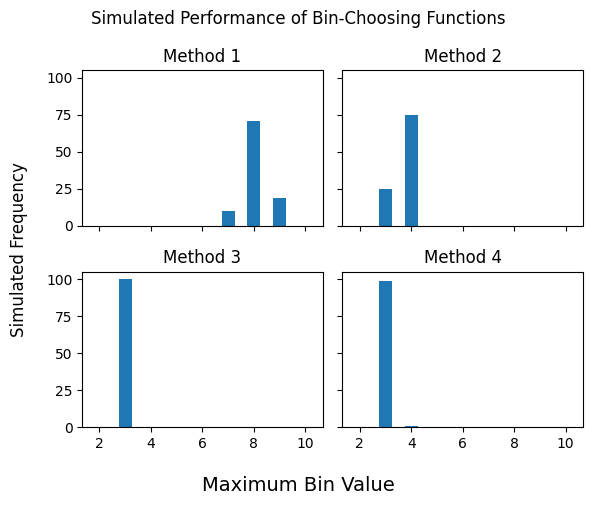

In [13]:
data = [
    ("Method 1", max_values_1),
    ("Method 2", max_values_2), 
    ("Method 3", max_values_3), 
    ("Method 4", max_values_4)]

# output raw data, since it's hard to see in the histogram plots
markdown("### Number of occurrences of maximum bin values")
for d in data:
    markdown(f'#### {d[0]}')
    sorted_occurences = sorted(Counter(d[1]).items())
    print(', '.join(f'{key}: {val}' for key, val in sorted_occurences))
    # print(sorted(Counter(d[1]).items()))

# fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(10,3))
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6,5))
for ax, d in zip(axes.flatten(), data):
    ax.hist(d[1], bins=range(2,12), rwidth=.5, align='left')
    ax.set_title(d[0])
fig.subplots_adjust(hspace=2.0, wspace=1.0)
fig.suptitle("Simulated Performance of Bin-Choosing Functions")
fig.supxlabel("Maximum Bin Value", size=14)
fig.supylabel("Simulated Frequency")
fig.tight_layout()

### Analysis

Looks like we can rank the performance as follows: 3 > 4 > 2 > 1; 4 perform only slightly worse than 3. I did not expect 4 to perform better than 2, but in retrospect it makes sense: random numbers tend to cluster, and could even be the same twice in a row! Method 4 guarantees that the 2 choices of bin are not the same, and probably also aleves the clustering issue more generally. The run time of 4 was better than 2 and 3, too, since the implementation was also simpler, so it does stand out as a possible sweet spot, assuming that over time the runtime improvement over method 1 outweighs the loss caused by a more complex algorithm.

I do have an open question regarding the resolution of ties. Methods 2 and 3 resolve ties via random choice; I tried deterministically choosing the first bin in method 2, but there was no change in final outcome (suggesting this is probably fine to do for time optimization). However, I also tried changing method 4 to use a random choice instead of always picking the first bin, and the final outcomes worsened, matching method 2 almost perfectly. Why would this be?

<div class="alert alert-block alert-info">

(c) (5 points) Propose an analogy between the first of the random processes above and the standard implementation of hashing N elements into a hash table with N buckets, and resolving collisions via chaining (i.e., one linked list per bucket). Discuss in particular any relationships between X and search times in the hash table.

</div>

The hypothetical hash table performance can be compared to strategy 1 above: a pseudo-random hash function picks the bucket to put a value in, just as the function placed balls in random bins. The maximum number of balls in a bin is analogous to the number of values placed in a single bucket (in Java these are all placed in `TreeMap` when possible, otherwise a `LinkedList`). The maximum numbers in the ball-tossing simulation indicate the maximum number of iterate-and-compare steps required to find a value in the hash table.

<div class="alert alert-block alert-info">

(d) (5 points) Do the other random processes suggest alternative implementations of hash tables with chaining? Discuss the trade-offs between the different hash table implementations that you propose (e.g., in terms of insertion time vs. search time).

</div>

One could use multiple hash functions to place a value into one of multiple buckets, choosing the bucket with the fewest entries. Then the query method would search through all of the relevant buckets. The total number of iterations should still be the same on average, but the worst case performance should occur less often because we will do a better job of distributing the values. It's possible that the CPU cache behavior would be a worse, since we would access more disparate memory locations more often. Not sure about that, though.

<div class="alert alert-block alert-info">

# Part 2: Conservative Updates in a Count-Min Sketch

</div>

In [14]:
from hashlib import md5
from random import shuffle
from statistics import mean


<div class="alert alert-block alert-info">

## Goal
The goal of this part is to understand the count-min sketch (from Lecture #2) via an implementation, and to explore the benefits of a “conservative updates” optimization.

</div>

<div class="alert alert-block alert-info">

## Description

You’ll use a count-min sketch with 4 independent hash tables, each with 256 counters. You
will run 10 independent trials. This lets you measure not only the accuracy of the sketch, but the distribution of the accuracy over multiple datasets with the same frequency distribution. Your sketch should take a “trial” as input, and the hash value of an element x during trial i (i = 1, 2, . . . , 10) for table j (j = 1, 2, 3, 4) is calculated as follows:

* Consider the input x as a string, and append i − 1 as a string to the end of the string.
* Calculate the MD5 score of the resulting string. Do not implement the MD5 algorithm yourself; most modern programming languages have packages that calculate MD5 scores for you. For example, in Python 3, you can use the hashlib library and `hashlib.md5(foo.encode('utf-8')).hexdigest()` to compute the MD5 score of the string foo (returning a hexadecimal string).
* The hash value is the j-th byte of the score.

As an example, to compute the hash value of 100 in the 4th table of the 9th trial, we calculate the MD5 score of the string "1008", which is (in hexadecimal):

    15 87 96 5f b4 d4 b5 af e8 42 8a 4a 02 4f eb 0d

The 4th byte is 5f in hexadecimal, which is 95 in decimal. In Python, you can parse the hexadecimal string 5f with `int("5f", 16)`.

(a) (5 points) Implement the count-min sketch, as above.

</div>

In [15]:
# returns an array of hash values to use for assignng buckets in the count-min hash sketch
def count_min_hashes(x, trial):
    return md5(f"{x}{trial - 1}".encode())

assert count_min_hashes(100, 9).hexdigest() == "1587965fb4d4b5afe8428a4a024feb0d"
"OK"

'OK'

In [16]:
# Note: assignment says to use digest indices j=1..4, but it was easier to work with 0..3
class CountMinSketch:
    def __init__(self, trial: int, conservative: bool=False):
        """Create a new count min sketch. 
        - trial: used to seed the hash function for experiments in this notebook
        - conservative: use conservative update optimization"""
        self.table = [[0] * 256 for i in range(4)]
        self.trial = trial
        self.conservative = conservative
        self.total = 0
    
    def increment(self, x):
        self.total += 1
        
        digest = count_min_hashes(x, self.trial).digest()
        if self.conservative:
            min_val = min(
                self.table[0][digest[0]],
                self.table[1][digest[1]],
                self.table[2][digest[2]],
                self.table[3][digest[3]]
                )
            for index, table in enumerate(self.table):
                if table[digest[index]] == min_val:
                    table[digest[index]] += 1
        else:
            self.table[0][digest[0]] += 1
            self.table[1][digest[1]] += 1
            self.table[2][digest[2]] += 1
            self.table[3][digest[3]] += 1

    def count(self, x):
        digest = count_min_hashes(x, self.trial).digest()
        return min([
            self.table[0][digest[0]], 
            self.table[1][digest[1]], 
            self.table[2][digest[2]], 
            self.table[3][digest[3]]])

In [17]:
def run_trials(stream, conservative=False):
    sketches = []
    for trial in range(1, 11):
        sketch = CountMinSketch(trial, conservative)
        for el in stream:
            sketch.increment(el)
        sketches.append(sketch)
    return sketches

<div class="alert alert-block alert-info">

You will be feeding data streams (i.e., sequences of elements) into count-min sketches. Every element of each stream is an integer between 1 and 9050 (inclusive). The frequencies are given by:
* Integers $1000 \times (i − 1) + 1$ to $1000 \times i$, for $1 ≤ i ≤ 9$, appear i times in the stream. That is, the integers 1 to 1000 appear once in the stream; 1001 to 2000 appear twice; and so on.
* An integer $9000 + i$, for $1 ≤ i ≤ 50$, appears $i^2$ times in the stream. For example, the integer 9050 appears 2500 times.

(Each time an integer appears in the stream, it has a count of 1 associated with it.)

In [18]:
def create_stream():
    stream = []
    for i in range(1, 10):
        sub_stream = range(1000 * (i-1) + 1, 1000 * i + 1)
        for j in range(i):
            stream.extend(sub_stream)
    for i in range(1, 51):
        stream.extend([9000 + i] * (i**2))
    return stream

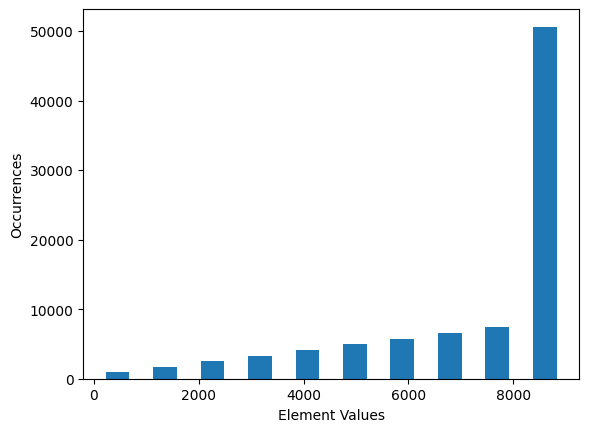

In [19]:
# Confirming distribution of values in created stream
stream = create_stream()

fig, ax1 = plt.subplots()
ax1.hist(create_stream(), rwidth=.5)
ax1.set_ylabel("Occurrences")
ax1.set_xlabel("Element Values")
None

<div class="alert alert-block alert-info">

(b) (2 points) Call an integer a heavy hitter if the number of times it appears is at least 1% of the total number of stream elements. How many heavy hitters are there in a stream with the above frequencies?

</div>

In [20]:
def heavy_hitters(stream):
    total = len(stream)
    freqs = Counter(stream)
    threshold = total / 100
    heavies = []
    for (k, v) in freqs.items():
        if v >= threshold:
            heavies.append(k)
    return heavies

hh = heavy_hitters(create_stream())
print(f"The heavy hitters are the values {hh[0]} through {hh[-1]}")

The heavy hitters are the values 9030 through 9050


<div class="alert alert-block alert-info">

Next, you will consider 3 different data streams, each corresponding to the elements above in a different order.

1. Forward: the elements appear in non-decreasing order.
2. Reverse: the elements appear in non-increasing order.
3. Random: the elements appear in a random order.

</div>

In [21]:
def forward_stream():
    stream = create_stream()
    return sorted(stream)

def reverse_stream():
    stream = create_stream()
    return sorted(stream, reverse=True)

def random_stream():
    stream = create_stream()
    shuffle(stream)
    return stream

assert forward_stream()[:10] == list(range(1, 11))
assert reverse_stream()[:10] == [9050] * 10
# too difficult to check this automatically
print('Confirm that this stream looks shuffled:')
print(random_stream()[:10])

Confirm that this stream looks shuffled:
[9025, 9037, 2521, 7505, 2396, 9030, 4836, 9049, 6376, 6988]


<div class="alert alert-block alert-info">

(c) (6 points) For each of the three data streams, feed it into a count-min sketch (i.e., successively insert its elements), and compute the values of the following quantities, averaged over the 10 trials, for each order of the stream:

* The sketch’s estimate for the frequency of element 9050.
* The sketch’s estimate for the number of heavy hitters (elements with estimated frequency at least 1% of the stream length).

Record the mean estimate for each of the three orders. Does the order of the stream affect the estimated counts? Explain your answer.

</div>

In [22]:
forward_stream_sketches = run_trials(forward_stream())
reverse_stream_sketches = run_trials(reverse_stream())
random_stream_sketches = run_trials(random_stream())

The order of the stream passed into a count-min sketch does not matter at all; count-min sketches only store frequencies, completely ignoring ordering of any kind. Therefore, the accumulated data will be exactly the same, and thus the estimated counts will also be exactly the same. Verification below:

In [23]:
for forward_sketch, reverse_sketch, random_sketch in zip(
    forward_stream_sketches, reverse_stream_sketches, random_stream_sketches
):
    assert forward_sketch.table == reverse_sketch.table == random_sketch.table
    markdown(f"* Trial {forward_sketch.trial} sketches are identical")
print("Sketches for all trials are identical")

* Trial 1 sketches are identical

* Trial 2 sketches are identical

* Trial 3 sketches are identical

* Trial 4 sketches are identical

* Trial 5 sketches are identical

* Trial 6 sketches are identical

* Trial 7 sketches are identical

* Trial 8 sketches are identical

* Trial 9 sketches are identical

* Trial 10 sketches are identical

Sketches for all trials are identical


Therefore, we don't need to report separate numbers for each data stream.

In [24]:
def sketch_statistics(sketches):
    threshold = forward_stream_sketches[0].total / 100
    heavy_hitter_count = []
    for sketch in sketches:
        count = 0
        for i in range(1,9051):
            if sketch.count(i) >= threshold:
                count += 1
        heavy_hitter_count.append(count)
    estimated_highest_count =  mean([sketch.count(9050) for sketch in sketches])
    return heavy_hitter_count, mean(heavy_hitter_count), estimated_highest_count

In [25]:
heavy_hitter_count, avg_heavy_hitters, estimated_highest_count = sketch_statistics(forward_stream_sketches)
markdown(f'* The average estimated count of element 9050 is {estimated_highest_count}')
markdown(f'* The estimated number of heavy hitters in each trial were {heavy_hitter_count}')
markdown(f'* The average estimate was {avg_heavy_hitters}')

* The average estimated count of element 9050 is 2645.7

* The estimated number of heavy hitters in each trial were [24, 24, 24, 25, 23, 24, 24, 23, 24, 23]

* The average estimate was 23.8

<div class="alert alert-block alert-info">


(d) (3 points) Implement the conservative updates optimization, as follows. When updating the counters during an insert, instead of incrementing all 4 counters, we only increment the subset of these 4 counters that have the lowest current count (if two or more of them are tied for the minimum current count, then we increment each of these).

</div>

#### Implementation Notes

The `CountMinSketch` class above was refactored to take a `conservative` flag in the constructor which turns on this optimization. The implementation was straightforward, but one structural difference I needed to account for was that it was no longer possible to get the total number of elements aded to the sketch using `sum(sketch.table[0])` as before; since not all of the tables are updated on each `increment` call, the tables can no longer answer the question "how many items have we seen"? This was easy to make up for with a separate `total` field.

<div class="alert alert-block alert-info">

(e) (3 points) Explain why, even with conservative updates, the count-min sketch never underestimates the count of a value.

</div>

The minimum value of the four tables constitutes a count-min sketch's best guess of the frequency of an element. Even with the conservative optimization, we always update this minimum value for each element encountered, so it is still equal to or greater than the actual number of occurrences of an element. Note also that it's important that we update all tables when there's a tie for the minimum value, since skipping the update for any of them would cause the sketch to underestimate the frequency of an item.

<div class="alert alert-block alert-info">

(f) (6 points) Repeat part (c) with conservative updates.

</div>

In [26]:
forward_stream_sketches_2 = run_trials(forward_stream(), True)
reverse_stream_sketches_2 = run_trials(reverse_stream(), True)
random_stream_sketches_2 = run_trials(random_stream(), True)

As shown below, when using the conservative update optimization the order of inputs *does* change the final state of the count-min sketches:

In [27]:
all_identical = True
for forward_sketch, reverse_sketch, random_sketch in zip(
    forward_stream_sketches_2, reverse_stream_sketches_2, random_stream_sketches_2
):
    all_identical = all_identical and (
        forward_sketch.table == reverse_sketch.table == random_sketch.table
    )
    if all_identical:
        markdown(f"* Trial {forward_sketch.trial} sketches are identical")
    else:
        markdown(f"* Trail {forward_sketch.trial} sketches are not identical; breaking now")
        break
if all_identical:
    print("Through some miracle (or more likely a bug), sketches for all trials are identical")
else:
    print("The sketches are not all identical (the expected outcome)")

* Trail 1 sketches are not identical; breaking now

The sketches are not all identical (the expected outcome)


In [28]:
data = [
    ("sorted stream", forward_stream_sketches_2), 
    ("reverse sorted stream", reverse_stream_sketches_2), 
    ("shuffled stream", random_stream_sketches_2)]

for name, stream in data:
    heavy_hitter_count, avg_heavy_hitters, estimated_highest_count = sketch_statistics(stream)
    markdown(f'#### Results for {name}')
    markdown(f'* The average estimated count of element 9050 is {estimated_highest_count}')
    markdown(f'* The estimated number of heavy hitters in each trial were \\{heavy_hitter_count}')
    markdown(f'* The average estimate was {avg_heavy_hitters}')

#### Results for sorted stream

* The average estimated count of element 9050 is 2577.2

* The estimated number of heavy hitters in each trial were \[22, 22, 23, 23, 22, 22, 22, 22, 22, 22]

* The average estimate was 22.2

#### Results for reverse sorted stream

* The average estimated count of element 9050 is 2500

* The estimated number of heavy hitters in each trial were \[21, 21, 22, 22, 21, 21, 21, 21, 21, 21]

* The average estimate was 21.2

#### Results for shuffled stream

* The average estimated count of element 9050 is 2500

* The estimated number of heavy hitters in each trial were \[21, 21, 22, 22, 21, 21, 21, 21, 21, 21]

* The average estimate was 21.2

The conservative update optimization improved the count estimations for all stream types. Performance was worse with the forward-sorted stream than for the other two sorts, but it was still better than the estimation without the optimization.